In [793]:
'''
from google.colab import drive

drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\n"

In [794]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#%cd "/content/drive/MyDrive/Inteligencia Artificial"
data = pd.read_csv("dataus2024.csv")
data.shape

(557181, 24)

In [795]:
firms = pd.read_csv('firmsus2024.csv')
firms.shape

(5689, 7)

In [796]:
print(type(data.head()))

<class 'pandas.core.frame.DataFrame'>


In [797]:
# Concat de data con firms para jalar columnas de industria, nombre empresa en data
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ["firm", "Empresa", "status", "industria"]

data = pd.merge(data, firms1, on="firm", how="left")
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,2000,NaN,NaN,1,NaN,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0,"Agilent Technologies, Inc",activo,Industrias manufactureras


Calculo la variable columna de NetIncome y otras asociadas:

**Utilidad bruta = Gross Profit =** $Revenue - COGS$

**COGS = Cost of Good Sold; son los gastos VARIABLES; cambian con las ventas**

**Utilidad operativa antes de impuesto = Earnings before Onterests and Taxes**

**EBIT (Utilidad Operativa Antes de Impuestos) =** $Gross profit - SGAE$

*SGAE = Safe and General Administrative Expenses

**Net Income =** $EBIT - FINEXP - INCOMETAX + OTHERINCOME + EXTRAORDINARYITEMS$

*FINEXP = Pago de Intereses de Préstamos

*INCOMETAX = Pago de Impuesto Sobre la Renta

*OTHERINCOME = Otras ventas que no sean del core del negocio

*EXTRAORDINARYITEMS = Ventas extraordinarias

*ETB = Utilidad antes de impuesto

*NETINCOME = Utilidad neta, es decir, todas las ganancias menos los gastos

In [798]:
data["GROSSPROFIT"] = data["revenue"] - data["cogs"]
data["EBIT"] = data["GROSSPROFIT"] - data["sgae"]
data["NETINCOME"] = data["EBIT"] - data["finexp"] - data["incometax"] + data["otherincome"] + data["extraordinaryitems"]
data["EBT"] = data['EBIT'] - data["finexp"] + data["otherincome"] + data["extraordinaryitems"]
data['Effective_Tax_Rate'] = data['incometax'] / data['EBT']
data['NOPAT'] = data['EBIT'] * (1 - data['Effective_Tax_Rate'])
data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\2485459827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)


Cálculo de Valor de Mercado y Valor en Libros

Valor de Mercado = MARKET VALUE = $originalprice * sharesoutstanding$
originalprice = precio original de la acción
sharepitstanding = Número de acciones disponibles


Valor en Libros = BOOKVALUE = $totalassets - totalliabilities$

totalassets = total de activos (recursos)

totalliabilities = total de pasivos

In [799]:
data['BOOKVALUE'] = data['totalassets'] - data['totalliabilities']
data['MARKETVALUE'] = data['originalprice'] * data['sharesoutstanding']
data['BOOKMARKET'] = data['BOOKVALUE'] / data['MARKETVALUE']

El BOOK-TO-MARKET es una variable de "Control" que vamos a incluir en el modelo de regresión.

En estadística se le llama variable de control a aquellas variables independientes (explicativas) que en la disciplina de estudio se ha encontrado que tiene mucha correlación con la variable dependiente.

Generamos la $variable / ratio$ de earning per share, que será otra variable de control

**¿Qué es earning per share deflated by price?**

**¿Qué es Earnings?**

Earning se puede medir con alguna variable de utilidad.
Ejemplo:
- NETINCOME
- EBIT (Utilidad Operativa)

**EARNING PER SHARE = EPS =** $EARNINGS / shareoutstanding$

**EARNING PER SHARE DEFLATED BY PRICE = EPSP =** $EPS / originalprice$

In [800]:
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']
data['EPSP'] = data['EPS'] / data['originalprice']

Ahora calculamos los retornos de acción para todas las empresas (trimestrales y anuales)

**Retorno trimestral = QR =** adjprice / adjprice{t-1} -1

**Retorno anual = YR =** adjprice / adjprice{t-4} - 1

Retornos Continuos Compuestos:

ret trimestral = qr = log(adjprice) - log(adjprice{t-1}) = log(adjprice / adjprice{t-1})

ret anual = yr = log(adjprice) - log(adjprice{t-4})


Genero un úndice en el dataset por firm-quarter:

In [801]:
data['qdate'] = pd.PeriodIndex(data.q, freq = 'Q')
data.set_index(['firm', 'qdate'], inplace = True)
data.head()
data.index

MultiIndex([(     'A', '2000Q1'),
            (     'A', '2000Q2'),
            (     'A', '2000Q3'),
            (     'A', '2000Q4'),
            (     'A', '2001Q1'),
            (     'A', '2001Q2'),
            (     'A', '2001Q3'),
            (     'A', '2001Q4'),
            (     'A', '2002Q1'),
            (     'A', '2002Q2'),
            ...
            ('ZY_old', '2022Q1'),
            ('ZY_old', '2022Q2'),
            ('ZY_old', '2022Q3'),
            ('ZY_old', '2022Q4'),
            ('ZY_old', '2023Q1'),
            ('ZY_old', '2023Q2'),
            ('ZY_old', '2023Q3'),
            ('ZY_old', '2023Q4'),
            ('ZY_old', '2024Q1'),
            ('ZY_old', '2024Q2')],
           names=['firm', 'qdate'], length=557181)

Calcular los CC Returns para cada trimestre y anual de cada firma.

In [802]:
# Quarter returns
data['return_q'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))
# Yearly returns
data['return_y'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcule los rendimientos CC returns futuros (un cuarto por delante)

In [803]:
data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-1)
#data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-4)

#data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-1)
data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-4)

print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcular al menos 4 financial ratios para cada variable independiente que será usada para predecir el futuro stock return

**ROE (Return On Equity):** Ganancias netas / Inversión de capital de accionistas.

Mide rentabilidad y ediciencia de la empresa al momento de generar rendimientos para la inversión de capital de accionistas (eficacia del dinero de los accionistas una empresa para generar ganancias). Mayor ROE = Uso eficiente del capital. Lo escogí debido a que es un indicador directo de la rentabilidad del capital, ya que una empresa con un ROE alto es atractivo a los inversores porque les da a entender que pueden generar beneficios sólidos con sus inversiones.

In [804]:
# Return on Equity (ROE)
data['ROE'] = data['NETINCOME'] / data['BOOKVALUE']
data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\702537394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)


**NPM (Net Profit Margin):** Ganancias netas / Ingresos

Mide el porcentaje de ganancias que produce una compañia en comparación con sus ingresos. Tiene un enfoque en la rentabilidad de la empresa. Escogí este ratio debido a que un NPM alto quiere decir que la empresa tiene un buen control de costos y que sus operaciones son eficientes, por lo que puede ser clave para predecir el retorno futuro de las inversiones.

In [805]:
# Net Profit Margin
data['NPM'] = data['NETINCOME'] / data['revenue']
data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\3479908675.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


**ROIC (Return on Invested Capital):** Utilidad operativa neta después de impuestos / Capital invertido

Mide la eficiencia con la que una empresa usa su capital para generar utilidad. Un ROIC alto indica que la empresa está obteniendo un alto rendimiento por cada unidad unidad de capital invertido. Escogí este ratio porque es un indicador de la efectividad con la que una empresa usa su capital total para generar valor. ROIC alto es que una empresa usa su capital de manera eficiente, por lo que puede ser clave para predecir retornos futuros.

In [806]:
# Return on Invested Capital (ROIC)
data['ROIC'] = data['NOPAT'] / data['totalassets']
data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\4238890335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)


**OPM (Operating Profit Margin):** EBIT / Revenue

Mide el porcentaje de los ingresos que se convierte en utilidades operativas (excluyendo intereses, impuestos, etc). A mayor margen operativo, una empresa es más eficiente de convertir ventas en utilidades (gran capacidad de generar ganancias con las operaciones básicas). Escogí este ratio porque refleja la eficiencia operativa de una empresa, muestra cuánto d elos ingresos se convierten en beneficios operativos. Un OPM alto quiere decir que la empresa tiene control sobre sus costos operativos, lo cual puede ser un factor importante para generar retornos.

In [807]:
# Operating Profit Margin
data['OPM'] = data['EBIT'] / data['revenue']
data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\1534909035.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [808]:
data['CURRENTRATIO'] = data['currentassets'] / data['currentliabilities']
data['DEBTTOEQUITY'] = data['totalliabilities'] / data['BOOKVALUE']
data['GROSSMARGIN'] = data['GROSSPROFIT'] / data['revenue']
data['ROA'] = data['NETINCOME'] / data['totalassets']

### 1.2 Composición firme del mercado financiero estadounidense

1. Empresas activas por industria hay en la muestra

In [809]:
active_firms = data[data['status'] == 'activo'].groupby('industria')['Empresa'].nunique()
print(active_firms)

industria
-                                                                                                   2
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                     17
Comercio al por mayor                                                                              74
Comercio al por menor                                                                             141
Construcción                                                                                       47
Empresas de electricidad, gas y agua                                                               78
Industrias manufactureras                                                                        1499
Información en medios masivos                                                                     243
Minería, explotación de canteras y extracción de petróleo y gas                                   109
Otros servicios excepto actividades gubernamentales                     

In [810]:
total_active_firms = active_firms.sum()
print('Total de empresas activas en todas las industrias:', total_active_firms)

Total de empresas activas en todas las industrias: 3444


2. Tabla de estadísticas sobre el book value y el market value por industria.

In [811]:
# Calcular las estadísticas para 'BOOKVALUE' y 'MARKETVALUE' por industria
bookvalue_stats = data.groupby('industria')['BOOKVALUE'].describe()
marketvalue_stats = data.groupby('industria')['MARKETVALUE'].describe()

# Convertir el resultado de describe a un dataframe. Asignar títulos a las columnas
bookvalue_df = bookvalue_stats.apply(pd.Series).rename(columns=lambda x: f'BOOKVALUE: {x}')
marketvalue_df = marketvalue_stats.apply(pd.Series).rename(columns=lambda x: f'MARKETVALUE: {x}')

# Concatenar los dos df de manera horizontal
statistics = pd.concat([bookvalue_df, marketvalue_df], axis=1)

# Poner a "industria" como columna, no como índice
statistics.reset_index(inplace=True)

print(statistics)


                                            industria  BOOKVALUE: count  \
0                                                   -              31.0   
1   Agricultura, ganadería, aprovechamiento forest...            1019.0   
2                               Comercio al por mayor            6001.0   
3                               Comercio al por menor           12851.0   
4                                        Construcción            3431.0   
5                                        Corporativos              67.0   
6                Empresas de electricidad, gas y agua            8100.0   
7                           Industrias manufactureras           98278.0   
8                       Información en medios masivos           18365.0   
9   Minería, explotación de canteras y extracción ...           10794.0   
10  Otros servicios excepto actividades gubernamen...            1061.0   
11  Servicios de alojamiento temporal y de prepara...            4673.0   
12  Servicios de apoyo a 

**¿Qué se puede decir sobre el tamaño típico de una empresa en términos de valor de mercado y valor contable?**

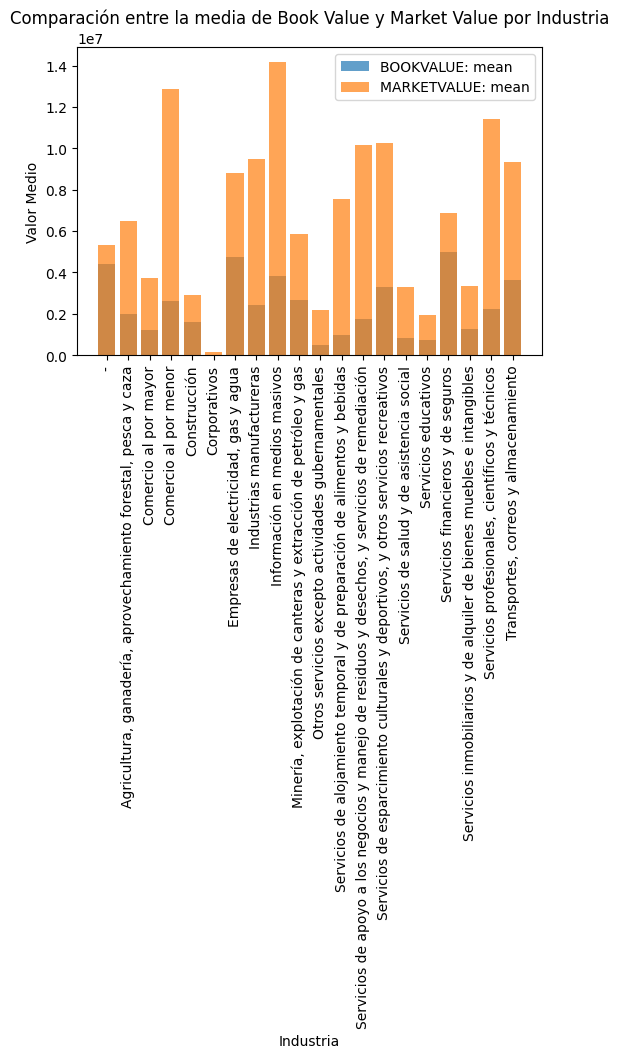

In [812]:
# Calcular la media de BOOKVALUE y MARKETVALUE por industria
bookvalue_mean = data.groupby('industria')['BOOKVALUE'].mean().reset_index()
marketvalue_mean = data.groupby('industria')['MARKETVALUE'].mean().reset_index()
bookvalue_mean = bookvalue_mean.rename(columns={'BOOKVALUE': 'BOOKVALUE_mean'})
marketvalue_mean = marketvalue_mean.rename(columns={'MARKETVALUE': 'MARKETVALUE_mean'})

# Unir ambas medias en un df para graficar
statistics = pd.merge(bookvalue_mean, marketvalue_mean, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics['industria'], statistics['BOOKVALUE_mean'], label='BOOKVALUE: mean', alpha=0.7)
plt.bar(statistics['industria'], statistics['MARKETVALUE_mean'], label='MARKETVALUE: mean', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Medio')
plt.title('Comparación entre la media de Book Value y Market Value por Industria')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

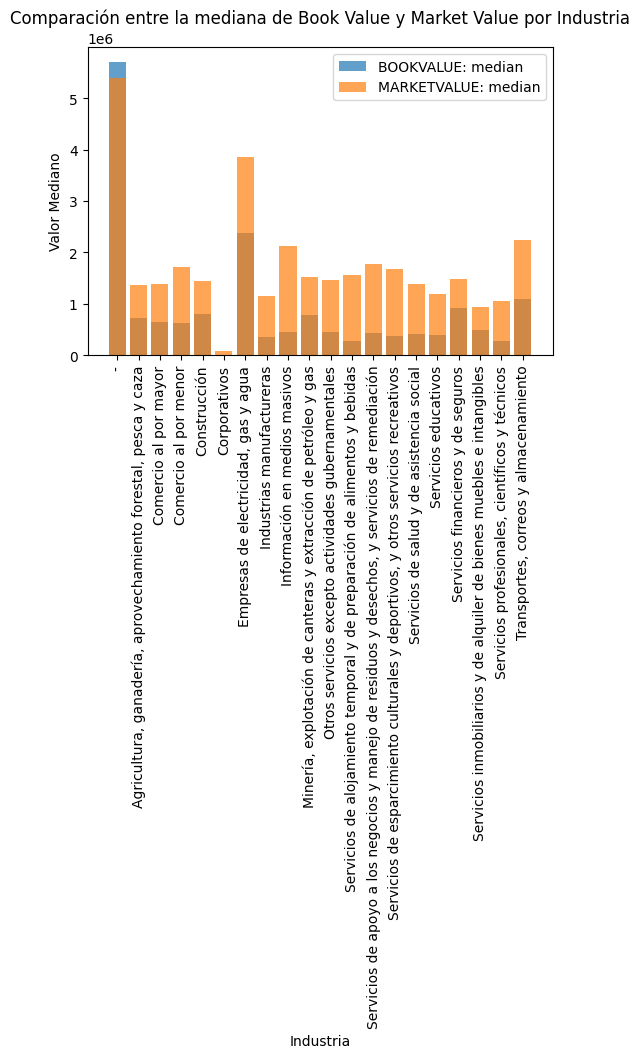

In [813]:
# Calcular la mediana de BOOKVALUE y MARKETVALUE por industria
bookvalue_median = data.groupby('industria')['BOOKVALUE'].median().reset_index()
marketvalue_median = data.groupby('industria')['MARKETVALUE'].median().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_median = bookvalue_median.rename(columns={'BOOKVALUE': 'BOOKVALUE_median'})
marketvalue_median = marketvalue_median.rename(columns={'MARKETVALUE': 'MARKETVALUE_median'})

# Unir ambas medianas en un df para graficar
stats_mediana = pd.merge(bookvalue_median, marketvalue_median, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(stats_mediana['industria'], stats_mediana['BOOKVALUE_median'], label='BOOKVALUE: median', alpha=0.7)
plt.bar(stats_mediana['industria'], stats_mediana['MARKETVALUE_median'], label='MARKETVALUE: median', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Mediano')
plt.title('Comparación entre la mediana de Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


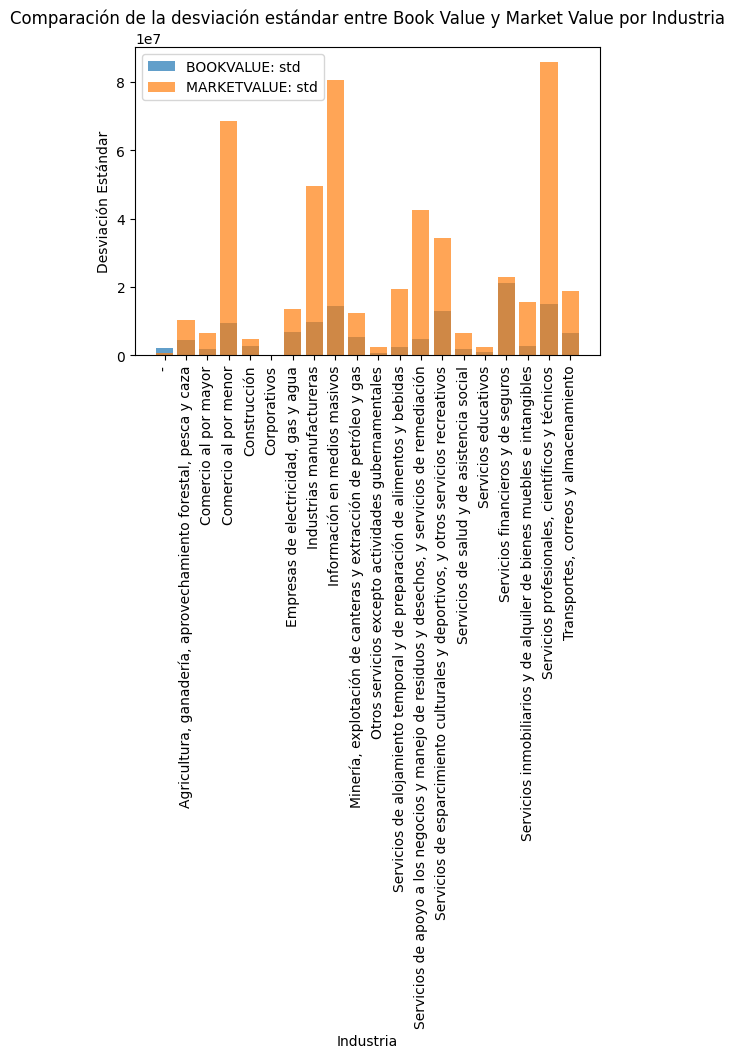

In [814]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la desviación estándar de BOOKVALUE y MARKETVALUE por industria
bookvalue_std = data.groupby('industria')['BOOKVALUE'].std().reset_index()
marketvalue_std = data.groupby('industria')['MARKETVALUE'].std().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_std = bookvalue_std.rename(columns={'BOOKVALUE': 'BOOKVALUE_std'})
marketvalue_std = marketvalue_std.rename(columns={'MARKETVALUE': 'MARKETVALUE_std'})

# Unir ambas desviaciones estándar en un df para graficar
statistics_std = pd.merge(bookvalue_std, marketvalue_std, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics_std['industria'], statistics_std['BOOKVALUE_std'], label='BOOKVALUE: std', alpha=0.7)
plt.bar(statistics_std['industria'], statistics_std['MARKETVALUE_std'], label='MARKETVALUE: std', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Desviación Estándar')
plt.title('Comparación de la desviación estándar entre Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


En la mayoría de las industrias, el Market Value mediano es bastante más alto que el Book Value mediano. Esto podría significar que el mercado suele valorar a las empresas más de lo que en verdad valen (BOOKVALUE). En otras palabras, el mercado tiende a sobrevalorar a las empresas, probablemente porque se espera que crezcan, tengan una buena reputación o generen ingresos futuros.

Cuando miramos la media de ambos valores (Market Value y Book Value), notamos que la media suele ser más alta que la mediana. Esto suele pasar porque hay algunas empresas muy grandes que hacen que la media suba, distorsionando un poco la realidad. Por eso, la mediana es generalmente una mejor medida para representar a la mayoría de las empresas, ya que no se ve tan afectada por esas pocas empresas enormes.

En términos de Market Value, el tamaño típico de una empresa muestra mucha variabilidad dentro de muchas industrias. Esto sugiere que hay grandes diferencias entre empresas, con algunas siendo mucho más grandes que otras en términos de valor de mercado.

Por otro lado, el Book Value es más uniforme entre las empresas de una misma industria, con menos variabilidad. Esto significa que las empresas son más parecidas en cuanto a su valor contable.

Entonces, mientras que el Market Value muestra grandes diferencias en el tamaño de las empresas, el Book Value es más consistente. Por ello, la mediana es una mejor medida para representar el tamaño típico de una empresa, ya que no se deja llevar tanto por esos valores extremos (outliers) y no se deja caer en sesgos.

**¿Cuánto cambian estas variables dentro de cada industria? :**


El Market Value presenta una gran variabilidad dentro de muchas industrias, lo cual se evidencia en las altas desviaciones estándar observadas en las gráficas. Esta variabilidad sugiere que, dentro de la misma industria, los valores de mercado de las empresas pueden fluctuar considerablemente, con algunas empresas alcanzando valores de mercado muy altos mientras que otras se mantienen en niveles mucho más bajos. Esta notable dispersión puede distorsionar el promedio, haciendo que la media no sea un reflejo preciso del tamaño típico de las empresas en la industria. Por ello, la mediana surge como una medida estadística mejor y representativa para describir el valor de mercado de la mayoría de las empresas, al ser menos sensible a la influencia de estos valores extremos.

Por otro lado, el Book Value muestra una menor variabilidad entre las industrias, lo que se traduce en desviaciones estándar mucho más bajas en comparación con el Market Value. Esto indica que los valores contables de las empresas son más homogéneos, con menos dispersión alrededor de la media. Dado que el Book Value de las empresas dentro de una industria tiende a estar más concentrado, la mediana sigue siendo una representación adecuada para describir el valor contable típico, ya que minimiza la influencia de cualquier empresa con un valor contable excepcionalmente alto o bajo.

Por lo tanto, aunque ambas variables presentan cambios dentro de cada industria, la variabilidad es más pronunciada en el Market Value que en el Book Value. Esto refuerza la necesidad de utilizar la mediana como una medida central más representativa en ambos casos, en especial para el Market Value, donde las diferencias entre empresas pueden ser más extremas.

**¿Cómo se distribuye el tamaño de la empresa (en valor de mercado)?**

La distribución del tamaño de las empresas, en términos de Market Value, muestra una considerable variabilidad dentro de muchas industrias. Esta variabilidad se refleja en la notable diferencia entre la media, la mediana y la alta desviación estándar observadas en los datos. La presencia de un sesgo positivo (a la derecha) indica que, aunque la mayoría de las empresas en cada industria tienen un valor de mercado relativamente bajo, ya que, existen algunas empresas con valores de mercado significativamente mayores, lo que eleva la media por encima de la mediana.

Dado este sesgo, la mediana surge como una medida más representativa del tamaño típico de las empresas dentro de cada industria, ya que es menos susceptible a la influencia de estos valores atípicos que distorsionan la media. Por lo tanto, al analizar el tamaño de las empresas, es preferible utilizar la mediana para obtener una visión más precisa y menos sesgada de la distribución del Market Value en cada sector.

3. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor de mercado y qué tan lejos están del tamaño de mercado típico de una empresa estadounidense?

In [815]:
# Ordenar las empresas por valor de mercado en orden descendente y agrupándolas por empresa (para que no se repitan empresas)
first_10_companies = data.groupby('Empresa')['MARKETVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names = first_10_companies.index

# Filtrar las primeras 10 empresas
first_10_data = data[data['Empresa'].isin(first_10_names)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de Market value
result = first_10_data.groupby('Empresa').agg({'industria': 'first', 'MARKETVALUE': 'sum'}).sort_values('MARKETVALUE', ascending=False)

# Imprimir las empresas
print(result)


                                                                industria  \
Empresa                                                                     
Apple Inc                                       Industrias manufactureras   
Microsoft Corp                              Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
Amazon.Com, Inc                                     Comercio al por menor   
Exxon Mobil Corp                                Industrias manufactureras   
Walmart Inc                                         Comercio al por menor   
Johnson & Johnson                               Industrias manufactureras   
General Electric Company                        Industrias manufactureras   
Meta Platforms, Inc       Servicios profesionales, científicos y técnicos   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   

                           MARKETVALUE  
Empresa                           

In [816]:
# Sumar todos los Market Values de todas las empresas
company_market_values = data.groupby('Empresa')['MARKETVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_market_value = company_market_values.median()
print('Tamaño típico del mercado:', median_market_value)

Tamaño típico del mercado: 34997992.625555396


In [817]:
# Distancia entre el tamaño de mercado típico y el Market Value del top 10 empresas
first_10_companies['distance_from_median'] = first_10_companies - median_market_value
print(first_10_companies['distance_from_median'])

Empresa
Apple Inc                   6.968498e+10
Microsoft Corp              6.807201e+10
Alphabet Inc                4.734901e+10
Amazon.Com, Inc             4.007766e+10
Exxon Mobil Corp            3.377943e+10
Walmart Inc                 2.542652e+10
Johnson & Johnson           2.501088e+10
General Electric Company    2.361824e+10
Meta Platforms, Inc         2.306267e+10
Jpmorgan Chase & Co         2.154043e+10
Name: MARKETVALUE, dtype: float64


In [818]:
# Calcular la diferencia
first_10_companies['percentage_difference'] = ((first_10_companies - median_market_value) / median_market_value) 
print(first_10_companies['percentage_difference'])

Empresa
Apple Inc                                                         1991.113744
Microsoft Corp                                                    1945.026045
Alphabet Inc                                                      1352.906426
Amazon.Com, Inc                                                   1145.141538
Exxon Mobil Corp                                                   965.181993
Walmart Inc                                                        726.513811
Johnson & Johnson                                                  714.637545
General Electric Company                                           674.845539
Meta Platforms, Inc                                                658.971147
Jpmorgan Chase & Co                                                615.476192
distance_from_median        Empresa
Apple Inc                   1990.11374...
Name: MARKETVALUE, dtype: object


Al analizar las 10 empresas estadounidenses más grandes en términos de valor de mercado, vemos que están en una liga totalmente distinta comparadas con el tamaño típico de una empresa en el mercado. Por ejemplo, Apple tiene un valor de mercado que es casi 2,000 veces mayor que la mediana del mercado. Esto demuestra que estas empresas, como Apple, Microsoft y Alphabet, concentran una parte enorme del valor total del mercado, lo que refleja una alta concentración y desigualdad.

El hecho de que estas empresas estén tan por encima de la mediana también resalta la importancia de usar la mediana como una mejor medida para representar el tamaño típico de una empresa, porque la media estaría completamente distorsionada por estas gigantes. Además, aunque estas empresas provienen de diferentes industrias, todas comparten la característica de tener un valor de mercado extremadamente alto en comparación con la mayoría de las otras empresas, lo que indica que dentro de sus industrias, son las líderes.

Es por eso que, estas 10 empresas están tan alejadas del tamaño de mercado típico que prácticamente operan en su propio espacio, lo que muestra un mercado muy concentrado donde unas pocas gigantes dominan.Las empresas con un mayor Market Value están alejadas de un 615 hasta un 1991 veces del tamaño típico de una empresa en US (lo cual, es demasiado), por lo que podemos decir que estas son las empresas que forman parte de los outliers de la distribución de MARKETVALUE.

4. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor contable y qué tan lejos están del tamaño contable típico de una empresa estadounidense?

In [819]:
# Ordenar las empresas por Book value en orden descendente y agrupándolas por empresa (para que no sea repitan empresas)
first_10_book = data.groupby('Empresa')['BOOKVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names_book = first_10_book.index

# Filtrar las primeras 10 empresas
first_10_data_book = data[data['Empresa'].isin(first_10_names_book)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de book value
result_book = first_10_data_book.groupby('Empresa').agg({'industria': 'first', 'BOOKVALUE': 'sum'}).sort_values('BOOKVALUE', ascending=False)

# Imprimir las empresas
print(result_book)

                                                                industria  \
Empresa                                                                     
Berkshire Hathaway Inc                 Servicios financieros y de seguros   
Bank Of America Corp                   Servicios financieros y de seguros   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   
Citigroup Inc                          Servicios financieros y de seguros   
Exxon Mobil Corp                                Industrias manufactureras   
Wells Fargo & Company                  Servicios financieros y de seguros   
Chevron Corp                                    Industrias manufactureras   
AT&T Inc                                    Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
General Electric Company                        Industrias manufactureras   

                             BOOKVALUE  
Empresa                           

In [820]:
# Sumar todos los Book Values de todas las empresas
company_book_values = data.groupby('Empresa')['BOOKVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_book_value = company_book_values.median()
print('Tamaño típico del mercado:', median_book_value)

Tamaño típico del mercado: 11830299.0


In [821]:
# Distancia entre el tamaño de mercado típico y el Book Value del top 10 empresas
first_10_book['distance_from_median'] = first_10_book - median_book_value
print(first_10_book['distance_from_median'])

Empresa
Berkshire Hathaway Inc      2.166258e+10
Bank Of America Corp        1.915877e+10
Jpmorgan Chase & Co         1.785957e+10
Citigroup Inc               1.578566e+10
Exxon Mobil Corp            1.416238e+10
Wells Fargo & Company       1.211942e+10
Chevron Corp                1.025700e+10
AT&T Inc                    1.009984e+10
Alphabet Inc                9.293003e+09
General Electric Company    8.575766e+09
Name: BOOKVALUE, dtype: float64


In [822]:
# Calcular diferencia
first_10_book['percentage_difference'] = ((first_10_book - median_book_value) / median_book_value) 
print(first_10_book['percentage_difference'])


Empresa
Berkshire Hathaway Inc                                            1831.109991
Bank Of America Corp                                              1619.466482
Jpmorgan Chase & Co                                               1509.646772
Citigroup Inc                                                     1334.341905
Exxon Mobil Corp                                                  1197.127537
Wells Fargo & Company                                             1024.438833
Chevron Corp                                                        867.01069
AT&T Inc                                                           853.726241
Alphabet Inc                                                       785.525622
General Electric Company                                           724.898475
distance_from_median        Empresa
Berkshire Hathaway Inc      1830.10999...
Name: BOOKVALUE, dtype: object


Al observar las 10 empresas estadounidenses más grandes en términos de valor contable (Book Value), queda claro que, al igual que con el valor de mercado, estas empresas están significativamente por encima del tamaño contable típico de una empresa estadounidense. Por ejemplo, Berkshire Hathaway tiene un valor contable que es aproximadamente 1831 veces mayor que la mediana del valor contable en el mercado. Esto indica que estas empresas poseen una cantidad de activos netos muy superior al promedio, lo que las coloca en una posición destacada dentro del mercado.

La mayoría de las empresas en esta lista pertenecen al sector de servicios financieros y de seguros, lo que puede decir que en esta industria se concentran empresas con activos muy grandes en comparación con otras industrias. 

Al igual que con el Market Value, la gran diferencia entre la mediana del valor contable y los valores de las empresas más grandes resalta la presencia de outliers significativos en el mercado. Esto reitera la importancia de utilizar la mediana como una medida más representativa del tamaño típico de una empresa, ya que la media sería muy influenciada por estos valores extremos.

Es por eso que, las 10 empresas más grandes en términos de valor contable están a una distancia muy grande del tamaño típico de las empresas en el mercado estadounidense. Esto refleja una gran concentración de activos en unas pocas empresas, especialmente en el sector financiero.

### 1.3 Evolución del mercado financiero de US
Considerando el historial completo de datos financieros de todas las empresas, y solo la información fiscal anual (seleccionando mes fiscal = 12):

1. ¿Cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años? Haz una tabla y/o gráfica y explica:



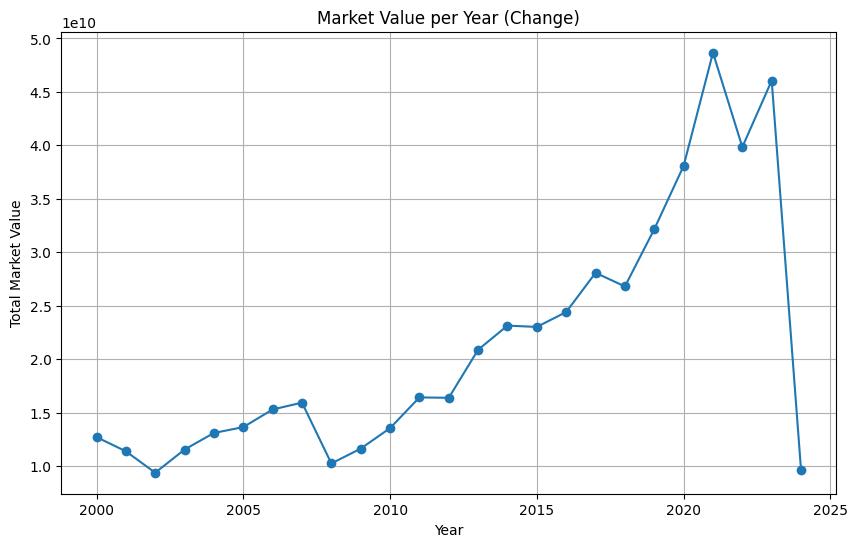

In [823]:
# Filtrar la información por año fiscal (cuando el mes sea 12)
data_per_year = data[data['fiscalmonth'] == 12]

# Calcular el MARKETVALUE total para cada año
total_market_value_per_year = data_per_year.groupby('year')['MARKETVALUE'].sum()

# Tabla por año de MKT Value
mkt_val_by_year = total_market_value_per_year.reset_index()
mkt_val_by_year.columns = ['Year', 'Market Value']

plt.figure(figsize=(10, 6))
plt.plot(mkt_val_by_year['Year'], mkt_val_by_year['Market Value'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Market Value')
plt.title('Market Value per Year (Change)')
plt.grid(True)
plt.show()


Esta gráfica nos cuenta la trayectoria de cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años. Desde el 2000 hasta 2019, podemos ver un crecimiento bastante constante en el valor del mercado. Aunque hubo algunas caídas y subidas pequeñas, la tendencia general fue hacia arriba, lo que muestra un mercado en expansión, con empresas cada vez más costosas.

En 2020, el mercado alcanzó un pico importante, probablemente impulsado por el auge de las empresas tecnológicas (debido a la pandemia y la digitalización de los negocios) y otros factores. Sin embargo, después de este pico, hay una caída bastante drástica, especialmente hacia 2024. Esta caída podría deberse a una corrección del mercado, problemas económicos o cambios en las políticas que afectaron el valor de las empresas.

La gráfica también destaca períodos de estabilidad, como entre 2010 y 2015, donde el crecimiento fue más moderado, reflejando un mercado más estable durante esos años.

En resumen, el valor total del mercado estadounidense creció de manera sólida durante dos décadas, alcanzó su punto más alto en 2020, pero luego experimentó una caída significativa, recordándonos lo volátil que puede ser el mercado financiero.

2. ¿Cómo han cambiado a lo largo de los años los ingresos totales y los ingresos netos totales de todas las empresas estadounidenses? Haz una tabla y/o gráfica y explica

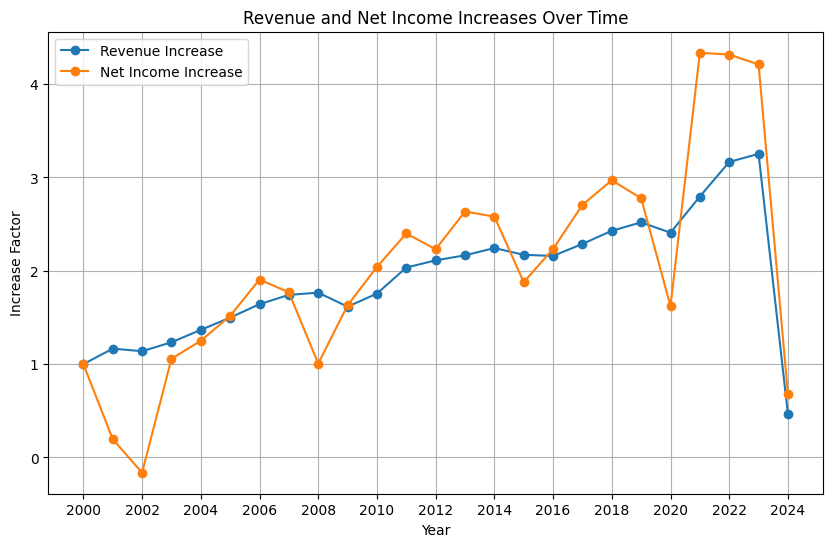

In [824]:
# Calcular el factor de incremento dividiendo cada valor por el primer valor de cada columna
total_revenue_per_year = data_per_year.groupby('year').agg({'revenue': 'sum', 'NETINCOME': 'sum'}).reset_index()
total_revenue_per_year.columns = ['Year', 'Revenue', 'Net Income']
mkt_val_by_year['Market Value Increase'] = mkt_val_by_year['Market Value'] / mkt_val_by_year.iloc[0]['Market Value']
total_revenue_per_year['Revenue Increase'] = total_revenue_per_year['Revenue'] / total_revenue_per_year.iloc[0]['Revenue']
total_revenue_per_year['Net Income Increase'] = total_revenue_per_year['Net Income'] / total_revenue_per_year.iloc[0]['Net Income']

# Graficar los factores de incremento
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Revenue Increase'], marker='o', linestyle='-', label='Revenue Increase')
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Net Income Increase'], marker='o', linestyle='-', label='Net Income Increase')
plt.xlabel('Year')
plt.ylabel('Increase Factor')
plt.title('Revenue and Net Income Increases Over Time')
plt.legend()

# Ajustar los ticks del eje x para mostrar solo cada dos años
plt.xticks(mkt_val_by_year['Year'][::2])

plt.grid(True)
plt.show()


A lo largo de los años, tanto los ingresos totales como los ingresos netos de las empresas estadounidenses han etnido cambios significativos. En general, ambos han mostrado un crecimiento sostenido desde el año 2000, lo que refleja un desempeño financiero positivo en el mercado.

Sin embargo, los ingresos netos han sido mucho más volátiles que los ingresos totales. Por ejemplo, en los primeros años, se puede ver que los ingresos netos cayeron considerablemente antes de volver a subir. Esta fluctuación sugiere que factores como cambios en costos, impuestos, o ganancias excepcionales han tenido un impacto más fuerte en las ganancias netas de las empresas.

Un gran punto a considerar es el aumento significativo en los ingresos netos alrededor de 2020, que incluso superó al incremento en los ingresos totales. Este pico podría haber sido impulsado por cambios en costos, activos, o cambios causados por la pandemia y su notable reducción de costos operativos y de packaging, a pesar de que los ingresos generales no crecieran al mismo ritmo.

Sin embargo, después de 2020, tanto los ingresos totales como los ingresos netos comenzaron a disminuir de manera notable, llegando a niveles cercanos a los del año 2000 hacia 2024. Esta caída podría estar relacionada con alguna crisis económica derivada al regreso de la pandemia así como que para el 2024 aún no tenemos los datos completos porque aún no termina.

### 1.4 Aprender sobre una industria

Industria seleccionada: Manufacturing industries

#### 1.4.1 Estadísticas descriptivas para su industria
Usando la submuestra de la industria "Manufacturing industries" y usando información fiscal anual (seleccionando filas con mes fiscal = 12) y el año completo más reciente (2023), haga lo siguiente:

- Muestre estadísticas descriptivas para el rendimiento de registro anual futuro, activos totales, ingresos, ingresos netos, variables de control y todos los índices financieros seleccionados. Proporcionar una interpretación clara de las estadísticas descriptivas de ingresos y 1 ratio financiero.

In [825]:
# Filtrar empresas manufactureras por industria en año fiscal
manuf_industry = data[(data['industria'] == 'Industrias manufactureras') &
                       (data['fiscalmonth'] == 12) &
                       (data['year'] == 2023)
]

# Select features
selected_features = ['return_y_future', 'totalassets', 'revenue', 'MARKETVALUE', 'BOOKVALUE', 'NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM', 'CURRENTRATIO', 'DEBTTOEQUITY', 'GROSSMARGIN', 'ROA', 'NOPAT', 'EBIT', 'BOOKMARKET', 'EPSP']

man_ind = manuf_industry[selected_features]

# Descriptive statistics
statistics = man_ind.describe()
print(statistics.round(2))

       return_y_future   totalassets       revenue   MARKETVALUE  \
count           179.00  1.471000e+03  1.471000e+03  1.414000e+03   
mean             -0.05  6.844456e+06  4.656406e+06  1.337376e+07   
std               0.70  2.551226e+07  1.973081e+07  8.527483e+07   
min              -3.24  4.360000e+00 -2.850820e+03  3.842900e+02   
25%              -0.31  9.825300e+04  8.564000e+03  8.802495e+04   
50%               0.09  5.046920e+05  2.687200e+05  7.105686e+05   
75%               0.34  2.732000e+06  2.222889e+06  4.287962e+06   
max               1.42  3.763170e+08  3.832850e+08  2.676737e+09   

          BOOKVALUE    NETINCOME      ROE       NPM     ROIC       OPM  \
count  1.471000e+03      1468.00  1468.00   1272.00  1467.00   1272.00   
mean   2.599635e+06    420341.30    -0.64    -55.30    -0.34    -42.90   
std    1.043731e+07   3246573.63    10.54    916.62     0.92    545.59   
min   -1.722800e+07  -6995000.00  -205.42 -31028.75   -13.08 -16785.75   
25%    2.843750e+

c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [826]:
# Calcular promedio ponderado (Sum de Numerador / Sum de Denominador)
weighted_avg_roe = man_ind['NETINCOME'].sum() / man_ind['BOOKVALUE'].sum()
weighted_avg_npm = man_ind['NETINCOME'].sum() / man_ind['revenue'].sum()
weighted_avg_roic = man_ind['NOPAT'].sum() / man_ind['totalassets'].sum()
weighted_avg_opm = man_ind['EBIT'].sum() / man_ind['revenue'].sum()

print(f"Promedio Ponderado ROE: {weighted_avg_roe:.4f}")
print(f"Promedio Ponderado NPM: {weighted_avg_npm:.4f}")
print(f"Promedio Ponderado ROIC: {weighted_avg_roic:.4f}")
print(f"Promedio Ponderado OPM: {weighted_avg_opm:.4f}")


Promedio Ponderado ROE: 0.1614
Promedio Ponderado NPM: 0.0901
Promedio Ponderado ROIC: 0.0629
Promedio Ponderado OPM: 0.1145


- El promedio ponderado del ROE dice que en promedio, las empresas manufactureras están generando un retorno del 16.14% sobre su patrimonio neto, lo cual, es bastante bueno, pues indica que las empresas en esta industria usan eficientemente su capital para generar beneficios. La media del ROE es -0.64, es negativa, así que sugiere que la mayoría de las empresas poseen pérdidas en vez de beneficios. Por otro lado, su mediana es 0, por lo que sugiere que la mayoría de las empresas tienen ROEs cercanos a 0, es decir, que apenas generan beneficios a partir de su patrimonio.
- El promedio ponderado de NPM nos dice que en promedio, las empresas manufactureras obtienen un beneficio de 9 centavos por cada dólar que se ingresa. Esto indica que las empresas pueden obtener una rentabilidad razonable después de cubrir sus gastos. Su media es NaN, debido a la presencia de valores extremos e infinitos (lo cual, distorsiona la realidad). Su mediana es -0.04, lo que indicaría que la mayoría de las empresas están tienen dificultades para obtener beneficios después de cubrir sus costos.
- El promedio ponderado de ROIC indica que  por cada dólar de capital invertido, las empresas manufactureras generan un retorno de 6.29 centavos por cada dólar invertido. La media es -0.34, podemos ver que es negativa, indicando que las empresas no logran generar gran valor sobre el capital invertido. La mediana es -0.03, indicando que la mayoría de las empresas están teniendo rendimientos bajos o nulos sobre el capital invertido.
- El promedio ponderado de OPM dice que las empresas están teniendo un beneficio operativo de 11.45 centavos por dólar de ingresos antes de considerar intereses e impuestos, lo que sugiere que las operaciones manufactureras son algo eficientes. La media es nan, de nuevo nos dice que los valores son tan extremos que distorsionan este cálculo. La mediana es -0.03, es negativa, por lo que indica que muchas de las empresas operan con pérdidas o que son ineficientes.

Con esto en mente, podemos concluir con que los promedios ponderados son significativamente más altos que las medias simples de los ratios, por lo que podemos intuir que las empresas más grandes logran mejores resultados financieros que las empresas pequeñas. Por otro lado, la mediana muestra que muchas de las empresas de la industria manufacturera tienen dificultades financieras, con márgenes operativos y retornos negativos en comparación con el capital. Por ello, el promedio ponderado de todos los ratios es la medida más adecuada para los finantial ratios, pues se muetra el alto impacto de las industrias comparado con el bajo impacto de las industrias pequeñas, dando una visión más clara del desempeño de la industria manufacturera.

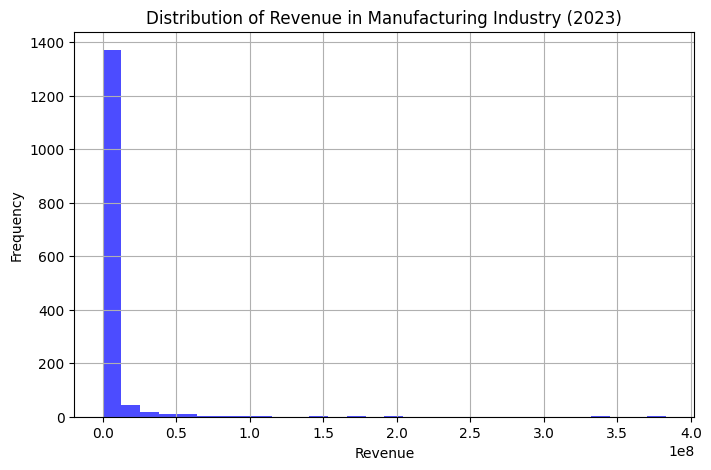

In [827]:
# Revenue
plt.figure(figsize=(8, 5))
plt.hist(man_ind['revenue'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

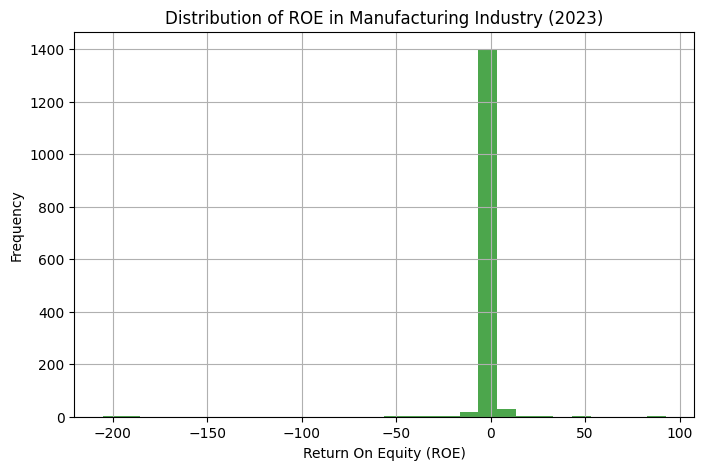

In [828]:
# ROE
plt.figure(figsize=(8, 5))
plt.hist(man_ind['ROE'].dropna(), bins=30, color='green', alpha=0.7)
plt.xlabel('Return On Equity (ROE)')
plt.ylabel('Frequency')
plt.title('Distribution of ROE in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

**REVENUE**

La gráfica de distribución del revenue en la industria manufacturera para el 2023 muestra una distribución bastante sesgada a la izquierda, además, muchas de las empresas de esta industria tienen ingresos bastante bajos en comparación con todas las empresas que se encuentran en los rangos más altos, que son pocas en comparación de las que se encuentran en los rangos bajos. Esto se refleja en la estadística descriptiva, donde la mediana de las empresas tienen aprox $268,720 de revenue, pero otras alcanzan hasta $383,285,000, lo cual, es muy comparable a la media, pues esta cifra es mucho mayor.

Este tipo de distribución da a entender que la mayoría de las empresas de la industria manfacturera son pequeñas o medianas, donde muy pocas generan ingresos enormes (generando sesgos gracias a ellas). Es por eso que se sugiere usar a la mediana para representar a la mayoría de las empresas. 

**ROE**

Mientras que, la ROE que nos dice la rentabilidad sobre el patrimonio, muestra una distribución donde muchas de las empresas tienen un ROE cercano a 0, es decir, que muchas de las empresas no están generando ganancias significativas en relación con sus propios fondos o incluso podrían estar operando con pérdidas. Los ROE negativos pueden indicar problemas financieros fuertes o pérdidas significativas en la industria. Sin embargo, se notan algunas empresas con ROEs muy grandes, lo que indica que esas compañías están obteniendo retornos significativos sobre su capital. 

Por ende, podemos decir que, la mayoría de las industrias manufactureras generan ingresos algo bajos y tienen un ROE bajo, lo que indica que están operando con márgenes reducidos y tienen dificultades para obtener retornos significativos sobre su capital.


#### 1.4.2 Matriz de correlación

Utilizando datos fiscales anuales (seleccionando filas con mes fiscal = 12) y todos los años:

Muestre una matriz de correlación con las mismas variables que utilizó para las estadísticas descriptivas anteriores, pero en el caso de activos totales, ingresos e ingresos netos, utilice la transformación logarítmica de sus valores. ¿Qué variables tienen una relación lineal más fuerte y significativa con los rendimientos de las acciones (rendimientos anuales)? Explicar

In [829]:
# Aplicar transformación logarítmica a 'totalassets', 'revenue', 'NETINCOME'
# Poner un caso para cuando se trate de calcular log de 0 (que es indefinido)
man_ind['log_totalassets'] = np.log(man_ind['totalassets'].replace(0, np.nan))
man_ind['log_revenue'] = np.log(man_ind['revenue'].replace(0, np.nan))
man_ind['log_NETINCOME'] = np.log(man_ind['NETINCOME'].replace(0, np.nan))

selected_features_log = ['return_y_future', 'log_totalassets', 'log_revenue', 'MARKETVALUE', 'BOOKVALUE', 'log_NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM', 'CURRENTRATIO', 'DEBTTOEQUITY', 'GROSSMARGIN', 'ROA', 'NOPAT', 'EBIT', 'BOOKMARKET', 'EPSP']
correlation_data = man_ind[selected_features_log].corr()
print(correlation_data.round(2))

                 return_y_future  log_totalassets  log_revenue  MARKETVALUE  \
return_y_future             1.00             0.28         0.32         0.14   
log_totalassets             0.28             1.00         0.87         0.29   
log_revenue                 0.32             0.87         1.00         0.26   
MARKETVALUE                 0.14             0.29         0.26         1.00   
BOOKVALUE                   0.07             0.44         0.37         0.47   
log_NETINCOME               0.01             0.88         0.87         0.37   
ROE                        -0.00             0.05         0.05         0.02   
NPM                         0.08             0.07         0.19         0.02   
ROIC                        0.39             0.54         0.52         0.08   
OPM                         0.08             0.08         0.24         0.02   
CURRENTRATIO                0.02            -0.17        -0.32        -0.07   
DEBTTOEQUITY               -0.03             0.01   

C:\Users\marif\AppData\Local\Temp\ipykernel_3380\1552686705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_ind['log_totalassets'] = np.log(man_ind['totalassets'].replace(0, np.nan))
c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\marif\AppData\Local\Temp\ipykernel_3380\1552686705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_

Text(0.5, 1.0, 'Correlation Matriz')

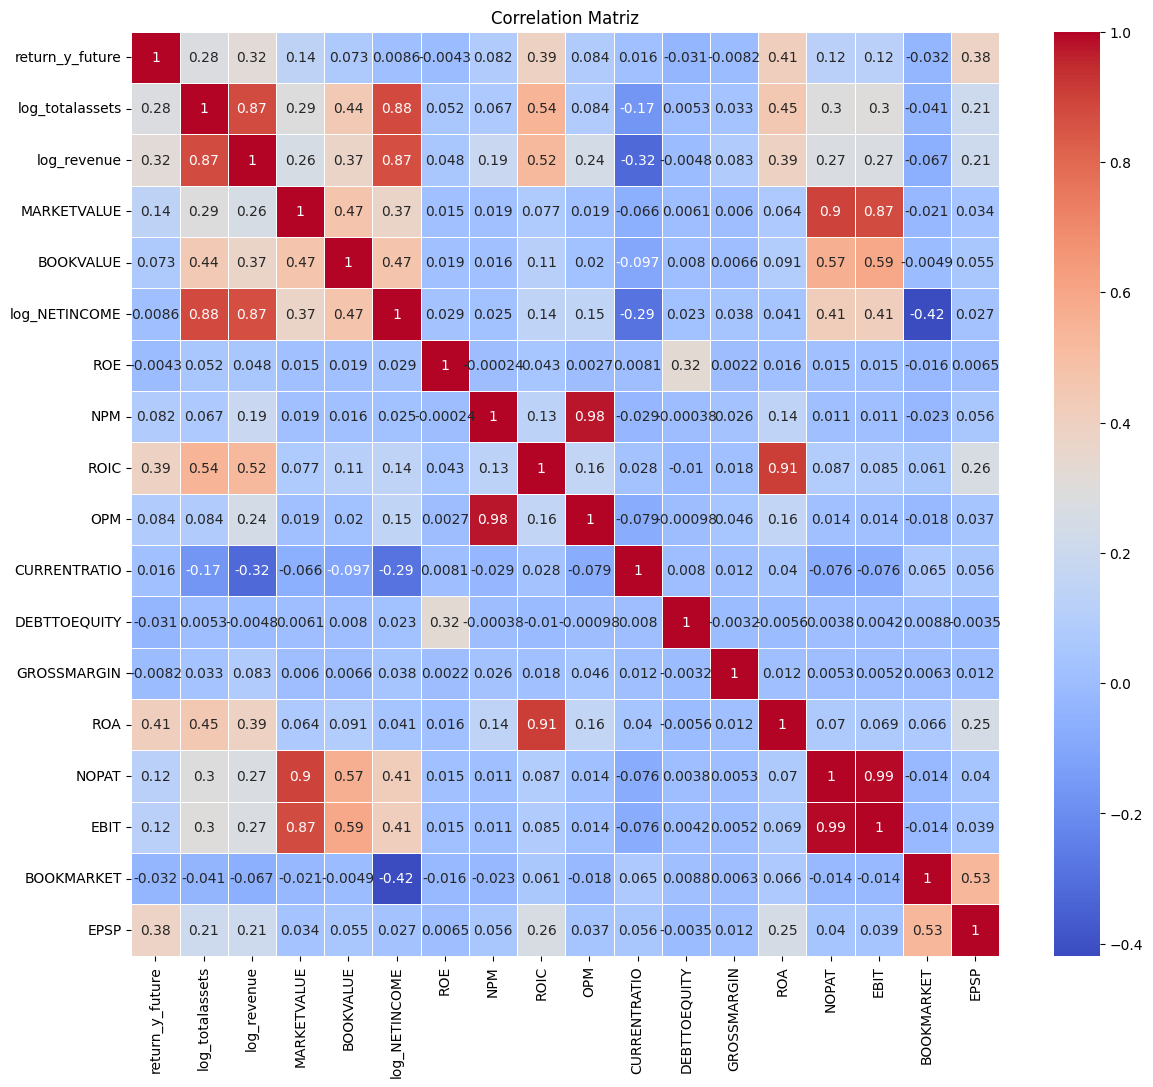

In [830]:
import seaborn as sns

# Crear la matriz de correlación con seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matriz')


En una matriz de correlación, cuanto más cercana es la correlación a 1 o -1, más fuerte es la relación lineal entre dos variables. Una correlación cercana a 1 indica una relación positiva fuerte, mientras que una correlación cercana a -1 indica una relación negativa fuerte. Teniendo esto en cuenta, podemos analizar qué variables tienen la relación más significativa con los rendimientos anuales (return_y_future).

# Variables con mayor correlación positiva con los rendimientos futuros:
- ROIC (0.39): La variable con la correlación más fuerte y positiva con los rendimientos anuales es el ROIC (Retorno sobre el Capital Invertido), con una correlación de 0.39. Esto sugiere que las empresas que son más eficientes en generar retornos sobre su capital invertido tienden a tener mejores rendimientos en el mercado de acciones. Este hallazgo tiene sentido, ya que el ROIC refleja la capacidad de una empresa para convertir su capital en beneficios, lo que generalmente se traduce en un mejor desempeño en el mercado de valores. Además, un alto ROIC indica que la empresa está utilizando de manera eficiente el capital disponible, lo que es un indicador clave de su capacidad para crecer y mantenerse competitiva.

- EPSP (0.38): El EPSP (Ganancias por Acción) también muestra una correlación alta y positiva con los rendimientos futuros. Esto indica que las empresas que pueden generar mayores ganancias por acción tienen más probabilidades de obtener mejores rendimientos en el mercado. Esta relación positiva tiene sentido, ya que un EPSP alto generalmente significa que la empresa está siendo rentable y generando valor para los accionistas, lo que aumenta la demanda de sus acciones y, por ende, el rendimiento de las mismas.

# Variables con correlación negativa con los rendimientos futuros:
- log_revenue (-0.32): Existe una correlación negativa entre el logaritmo de los ingresos y los rendimientos futuros. Esto podría sugerir que, en la industria manufacturera, el crecimiento en los ingresos no siempre se traduce en un mejor rendimiento en el mercado. Puede ser que algunas empresas generen ingresos significativos pero no logren convertir esos ingresos en beneficios operativos o financieros significativos.

- log_totalassets (-0.28): Al igual que con los ingresos, también encontramos una correlación negativa entre el tamaño de los activos de una empresa y sus rendimientos futuros. Esto podría indicar que las empresas más grandes, con mayores activos, no están necesariamente utilizando esos activos de manera eficiente para generar valor en el mercado de acciones. Las empresas manufactureras más grandes podrían estar enfrentando desafíos operativos o de gestión, lo que podría reducir su capacidad para generar rendimientos significativos.

# Variables con baja o nula correlación:
- ROE (-0.004): Aunque el ROE es una métrica ampliamente utilizada para medir la rentabilidad de una empresa, en este análisis muestra una correlación extremadamente baja con los rendimientos futuros, lo que sugiere que en este caso específico, la capacidad de una empresa para generar retornos sobre su patrimonio no está directamente relacionada con el desempeño futuro de sus acciones. Esto podría deberse a que, en muchas empresas, el ROE está influenciado por la estructura de capital y otros factores que no necesariamente se traducen en valor en el mercado de acciones.

- OPM (-0.084) y NPM (-0.082): Estas dos métricas de márgenes de beneficio también muestran correlaciones muy bajas con los rendimientos anuales. Esto indica que, aunque importantes para evaluar la eficiencia operativa de una empresa, no parecen ser determinantes del rendimiento en el mercado de acciones. En este caso, los márgenes operativos y netos pueden no estar siendo interpretados de manera favorable por los inversores, posiblemente porque no reflejan el verdadero potencial de crecimiento o la capacidad para aumentar el valor de las acciones a largo plazo.

- BOOKMARKET (-0.032) y MARKETVALUE (-0.14): Estas variables muestran correlaciones bajas o ligeramente negativas con los rendimientos futuros. Aunque el valor de mercado y el valor en libros son métricas importantes para evaluar la valoración de una empresa, su baja correlación con los rendimientos futuros sugiere que estos factores no están teniendo un impacto significativo en el rendimiento de las acciones en la industria manufacturera. 

#### 1.4.3 Modelo de regresión
Para cada ratio financiero, haga lo siguiente:
Hacer un histograma e interpretarlo.

Haga gráficos para visualizar la posible relación que podría tener cada factor con los rendimientos trimestrales (la variable dependiente).

Diseñe y ejecute una primera versión de un modelo de regresión múltiple para examinar si los índices seleccionados pueden explicar/predecir futuros rendimientos anuales de las acciones.

Debe comprobar posibles problemas de multicolinealidad. Explicar brevemente qué es la multicolinealidad, ejecutar e interpretar la prueba correspondiente.

Interpreta tu modelo

Interpreta con tus propias palabras los resultados de cada coeficiente (beta y su significancia estadística)

Interpretar el R cuadrado del modelo.

Escribe una conclusión de tus resultados.



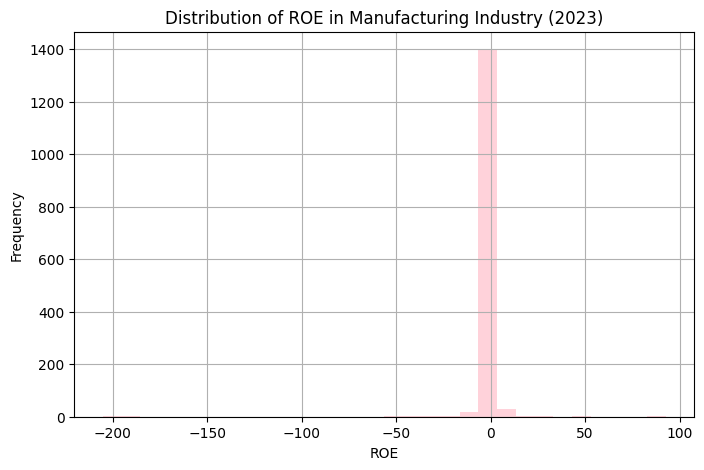

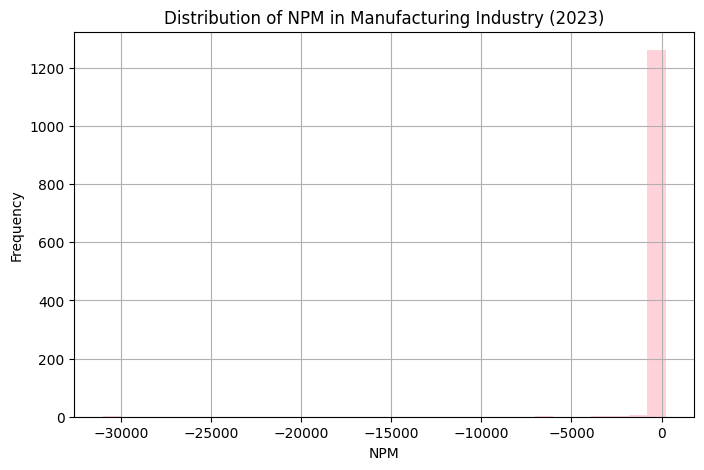

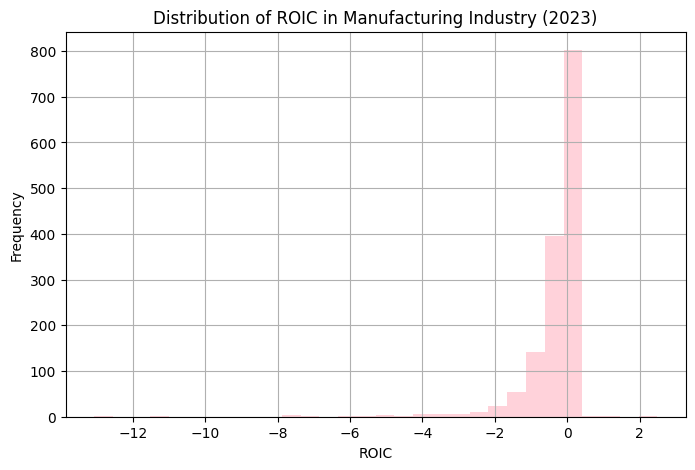

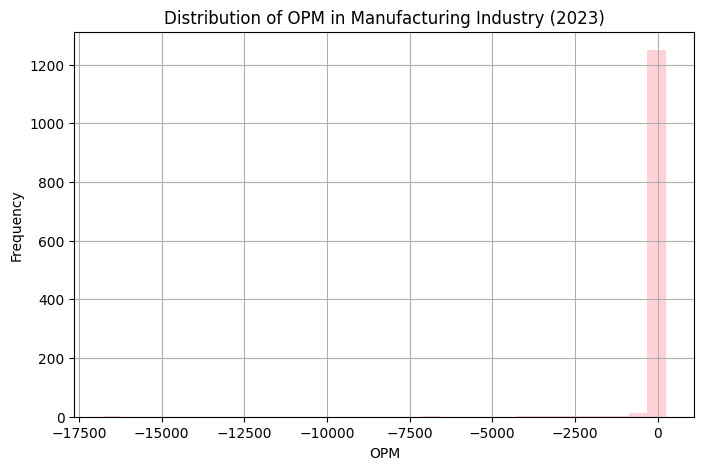

In [831]:
finantial_ratios = ['ROE', 'NPM', 'ROIC', 'OPM']

for ratio in finantial_ratios:
  plt.figure(figsize=(8, 5))
  # Reemplazar valores infinitos con nan
  valid_data = man_ind[ratio].replace([np.inf, -np.inf], np.nan)
  plt.hist(valid_data, bins=30, color='pink', alpha=0.7)
  plt.xlabel(ratio)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {ratio} in Manufacturing Industry (2023)')
  plt.grid(True)
  plt.show()

**Return on Equity**

La distribución de este histograma muestra que la empresa tiene un ROE cercano a 0, teniendo casi todos los valores en este número o cercano a este. Además, existen empresas con valores negativos para ROE (hasta en -200) y positivos hasta 100, por lo que muchas de las empresas tienen bajos retornos sobre su patrimonio, lo que puede significar dificultades para generar ganancias por accionistas (incluso llegando a tener pérdidas teniendo el ROE negativo).

**Net Profit Margin (NPM)**

Su histograma muestra que de igual manera, muchas de las empresas presentan un NPM bajo, incluso negativo,llegando hasta -3500%. Se puede ver un significante sesgo hacia la izquierda (negativos), pues muchas de las empresas al parecer están laborando con pérdidas.

**Return on Invested Capital (ROIC)**

Su distribución de igual manera se encuentra concentrada en valores negativos y en 0 (que es donde mayormente se encuentra). Muchas de las empresas se encuentran entre 0 y -2 pero tiene valores de hasta -10. El tener el ROIC bajo quiere decir que las empresas no están generando suficientes ganancias en relación con el capital invertido, por lo que muestra que no se está usando eficientemente el capital.

**Operating Profit Margin (OPM)**

Muestra una distribución bastante parecida a NPM (muchos de sus valores en negativos y muy pocos en positivos). Tener OPM negativo quiere decir que las operaciones básicas de las empresas no son rentables, por lo que puede tener un alto costo operativo y baja demanda de servicios o productos de la empresa.


En general, las empresas pelean por tener retornos positivos con sus operaciones, capital y capital invertido, por lo que puede indicar una época económica difícil.

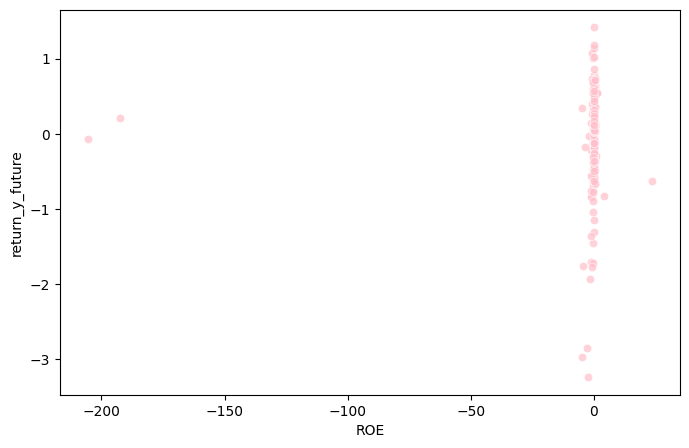

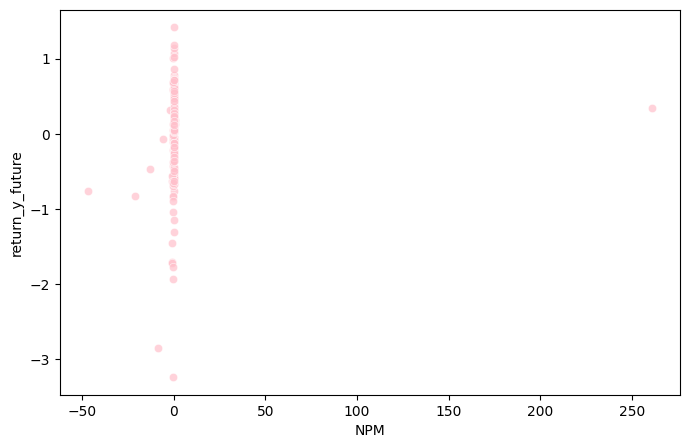

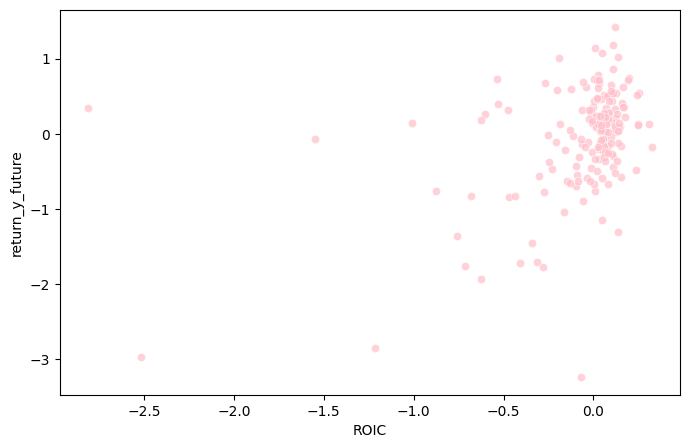

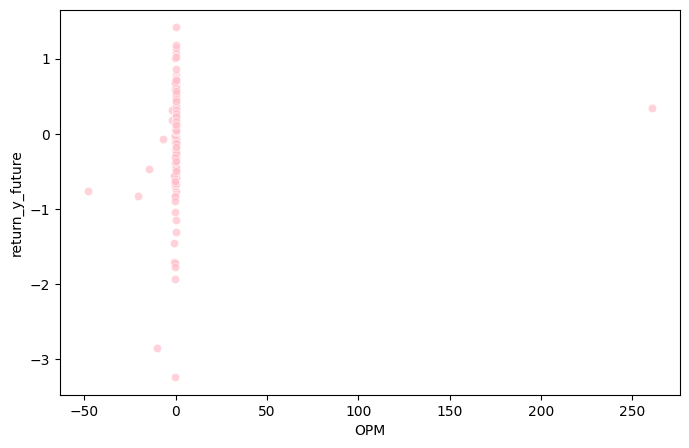

In [832]:
# Gráficas de relación: Ratios financiertos con rendimiento y futuro rendimiento
for ratio in finantial_ratios:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=ratio, y='return_y_future', data=man_ind, color='pink', alpha=0.7)
    plt.xlabel(ratio)
    plt.ylabel
    plt.show()


In [833]:
import statsmodels.api as sm
# Selección de variables
variables = ['OPM', 'ROIC', 'EPSP', 'BOOKMARKET' 'return_y_future']

# Filtrar los datos para 'Industrias manufactureras' y 'fiscalmonth' = 12
filter = data[(data['industria'] == 'Industrias manufactureras') & 
              (data['fiscalmonth'] == 12)]

# Calcular logaritmo de 'revenue'
log_revenue = np.log(filter['revenue'].replace(0, np.nan))

# Añadir 'log_revenue' al DataFrame filtrado
filter['log_revenue'] = log_revenue
data_variables = filter[['OPM', 'ROIC', 'EPSP', 'BOOKMARKET', 'return_y_future']]

# Separar las variables independientes y dependiente
X = data_variables[['OPM', 'ROIC', 'EPSP', 'BOOKMARKET']].copy()
y = data_variables['return_y_future'].copy()

# Reemplazar valores infinitos con nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = sm.add_constant(X)

# Crear el modelo OLS
model = sm.OLS(y, X, missing='drop').fit()

# Imprimir el resumen del modelo
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     155.6
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          2.42e-131
Time:                        21:21:51   Log-Likelihood:                -18101.
No. Observations:               19916   AIC:                         3.621e+04
Df Residuals:                   19911   BIC:                         3.625e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0112      0.004     -2.606      0.0

c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\marif\AppData\Local\Temp\ipykernel_3380\2613764952.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter['log_revenue'] = log_revenue


In [834]:
# Obtener la matriz hat
influence = model.get_influence()
hat_matrix = influence.hat_matrix_diag  # Valores diagonales de la matriz hat

# Calcular leverage points: un umbral común es 2(k+1)/n, donde k es el número de predictores y n el número de observaciones
k = X.shape[1]
n = X.shape[0]
leverage_threshold = 2 * (k + 1) / n

# Identificar leverage points
leverage_points = np.where(hat_matrix > leverage_threshold)[0]

print(f"Leverage threshold: {leverage_threshold}")
print(f"Leverage points: {leverage_points}")


Leverage threshold: 0.0004924289055767574
Leverage points: [   92    94   100   169   170   261   262   263   264   267   407   408
   419   428   590   628   762   768   812   840   905   925  1054  1194
  1195  1196  1298  1384  1396  1468  1520  1548  1562  1700  1721  1741
  1759  1815  1895  1896  1899  1963  1964  1968  2027  2141  2221  2222
  2336  2359  2368  2450  2494  2591  2757  2960  2961  2962  2963  2964
  2965  2966  2967  2968  2969  2971  3151  3171  3271  3300  3301  3337
  3451  3708  3711  3775  3921  3959  4135  4166  4515  4527  4810  5208
  5228  5525  5693  5701  5753  5849  5864  5895  6174  6218  6506  6573
  6582  6586  6588  6676  6874  7015  7018  7060  7061  7140  7331  7520
  7647  7648  7831  7833  7835  7892  8377  8379  8510  8516  8552  8602
  8603  8604  8605  8606  8607  8609  8646  8647  8648  8695  8933  8938
  8944  8948  8955  9001  9016  9379  9382  9385  9537  9538  9539  9541
  9562  9565  9653  9791  9845 10377 10839 10905 10961 11316 1133

In [835]:
import scipy.stats.mstats as mstats

# Winsorizar cada columna de las variables independientes de manera individual
X_winsorized = X.copy()
for col in X_winsorized.columns:
    X_winsorized[col] = mstats.winsorize(X_winsorized[col], limits=[0.05, 0.05])

# Asegúrate de que los índices de X_winsorized y y están alineados
X_winsorized = X_winsorized.reset_index(drop=True)
y = y.reset_index(drop=True)

# Volver a ajustar el modelo con los datos winsorizados
model_winsorized = sm.OLS(y, X_winsorized, missing='drop').fit()
print(model_winsorized.summary())


                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     357.1
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          1.52e-297
Time:                        21:21:51   Log-Likelihood:                -17869.
No. Observations:               20049   AIC:                         3.575e+04
Df Residuals:                   20044   BIC:                         3.579e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0134      0.006     -2.270      0.0

In [836]:
# Obtener influencia del modelo
influence = model_winsorized.get_influence()

# Obtener los residuals studentizados
studentized_residuals = influence.resid_studentized_internal

# Obtener Cook's Distance
cooks_distance, _ = influence.cooks_distance

# Identificar puntos influyentes basados en residuals studentizados y Cook's Distance
# Umbral común para residuals studentizados es > 3 o < -3
# Umbral común para Cook's Distance es 4/n (n = número de observaciones)
cooks_threshold = 4 / len(X_winsorized)

# Identificar puntos con residuals studentizados fuera de rango
high_residuals = np.where(np.abs(studentized_residuals) > 3)[0]

# Identificar puntos con Cook's Distance altos
high_cooks = np.where(cooks_distance > cooks_threshold)[0]

print(f"High studentized residuals points: {high_residuals}")
print(f"High Cook's Distance points: {high_cooks}")


High studentized residuals points: [   39   166   167   201   263   270   273   410   421   491   504   592
   614   630   698   719   794   815   929   971   999  1389  1402  1458
  1488  1510  1511  1519  1526  1559  1565  1583  1706  1711  1771  1823
  1824  1907  1908  1911  1912  1915  1954  1975  1976  2040  2046  2090
  2091  2104  2155  2182  2229  2235  2355  2413  2465  2472  2532  2594
  2603  2604  2691  2773  2774  2775  2828  2843  2944  2945  2992  3009
  3189  3302  3318  3338  3470  3562  3583  3610  3663  3728  3754  3791
  3795  3796  3941  3943  3973  3985  4156  4181  4378  4379  4481  4500
  4537  4539  4557  4591  4734  4924  4949  4980  4997  5257  5261  5535
  5555  5560  5562  5694  5732  5746  5785  5807  5817  5897  5927  5932
  5940  5988  6159  6207  6415  6457  6533  6608  6623  6624  6761  6800
  6914  7087  7184  7185  7375  7539  7541  7883  7938  8018  8085  8141
  8142  8468  8497  8601  8605  8628  8696  8697  8747  8960  8984  8988
  9005  9010  90

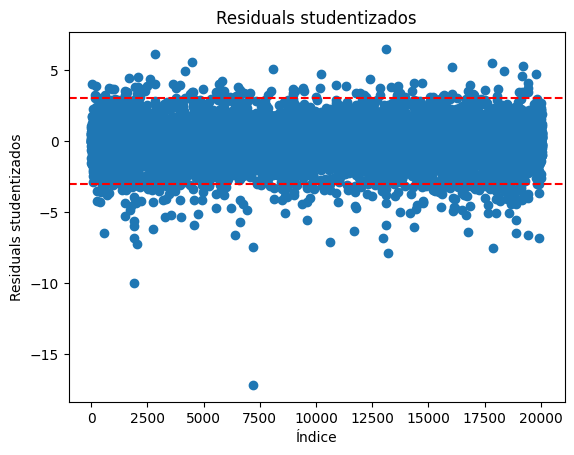

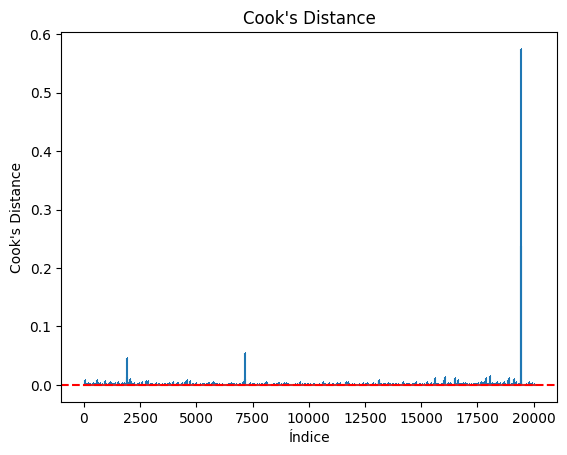

In [837]:
import matplotlib.pyplot as plt

# Gráfico de residuals studentizados
plt.scatter(range(len(studentized_residuals)), studentized_residuals)
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.title('Residuals studentizados')
plt.xlabel('Índice')
plt.ylabel('Residuals studentizados')
plt.show()

# Gráfico de Cook's Distance
plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt=",")
plt.axhline(y=cooks_threshold, color='r', linestyle='--')
plt.title('Cook\'s Distance')
plt.xlabel('Índice')
plt.ylabel('Cook\'s Distance')
plt.show()


In [838]:
# Winsorizar los puntos con residuals fuera del rango [-3, 3]
for idx in high_residuals:
    X_winsorized.iloc[idx] = mstats.winsorize(X_winsorized.iloc[idx], limits=[0.01, 0.01])

# Volver a ajustar el modelo después de winsorizar
model_winsorized_resid = sm.OLS(y, X_winsorized, missing='drop').fit()
print(model_winsorized_resid.summary())


                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     357.1
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          1.52e-297
Time:                        21:21:52   Log-Likelihood:                -17869.
No. Observations:               20049   AIC:                         3.575e+04
Df Residuals:                   20044   BIC:                         3.579e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0134      0.006     -2.270      0.0

In [839]:
# Dropear los puntos con Cook's Distance alto
X_dropped = X_winsorized.drop(high_cooks)
y_dropped = y.drop(high_cooks)

# Reajustar el modelo después de dropear
model_dropped_cooks = sm.OLS(y_dropped, X_dropped, missing='drop').fit()
print(model_dropped_cooks.summary())


                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     344.5
Date:                Wed, 04 Sep 2024   Prob (F-statistic):          1.20e-286
Time:                        21:21:53   Log-Likelihood:                -16624.
No. Observations:               18698   AIC:                         3.326e+04
Df Residuals:                   18693   BIC:                         3.330e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0130      0.006     -2.131      0.0

In [840]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reemplazar valores infinitos con NaN
X_winsorized.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas que contienen NaN
X_winsorized.dropna(inplace=True)

# Ahora puedes calcular el VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_winsorized.columns
vif_data["VIF"] = [variance_inflation_factor(X_winsorized.values, i) for i in range(X_winsorized.shape[1])]

print(vif_data)


     Variable       VIF
0       const  1.740618
1         OPM  1.049928
2        ROIC  1.867757
3        EPSP  1.819148
4  BOOKMARKET  1.049494


## Interpretación
### Coeficientes beta:
Los coeficientes beta representan la magnitud y cambio de la variable dependiente (DV), que en este caso es "return_y_future" (debido a que queremos predecir los retornos futuros) por cambio en la variable independiente (IV), que en este caso es un conjunto de variables: "ROIC", "log_totalassets", "log_revenue" y "OPM".
### P-value e Intervalo de Confianza
El intervalo de confianza estima el 95% de la probabilidad de que el coeficiente beta esté dentro del modelo de regresión, es decir, la probabilidad de que exista un 95% de confianza de que el intervalo contenga el verdadero valor de un parámetro.
Si el intervalo de confianza no incluye el 0, se sugiere que el coeficiente beta es estadísticamente significativo, pues la variable independiente tiene un efecto sobre la dependiente. Por otro lado, si el intervalo de confianza incluye el 0, no se puede descartar la probabilidad que el coeficiente beta sea 0, es decir, que la IV no tiene efecto sobre la DV.

Esto se relaciona con la hipótesis nula (H0) que dice que un coeficiente beta es 0, que indica que no hay relación lineal entre la IV y la DV, por lo que, al no incluir el 0 en el intervalo de confianza, se puede descartar la hipótesis nula, mientras que, cuando el intervalo de confianza incluye el 0, quiere decir que no hay evidencia suficiente para rechazar la hipótesis nula (no se puede afirmar que existe una relación significativa entre las variables).

El p-value dice qué tan probable es que el coeficiente beta ocurra por mera casualidad, por lo que se usa un umbral de significancia de 0.05 para ver si se considera significativo y que se pueda rechazar la hipótesis nula. Si el p-value es menor a 0.05, el intervalo de confianza del 95% no va a incluir al 0, indicando que el beta es significativamente diferente de 0 y que por ende, tiene efecto en la variable y (que queremos predecir).

### Coeficientes beta obtenidos y su análisis
- ROIC
    - Coeficiente Beta: 0.2803
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.266, 0.294]
    - Por cada unidad de aumento de ROIC, return_y_future aumentará 0.2803 unidades. El p-value es extremadamente bajo, lo que indica que el coeficiente es altamente significativo. El intervalo de confianza, que va de 0.266 a 0.294, no incluye el 0, lo que confirma que existe una relación positiva y significativa entre ROIC y los retornos futuros, sugiriendo que las empresas que son más eficientes en el uso de su capital tienden a generar mayores rendimientos futuros.
- log_totalassets
    - Coeficiente Beta: -0.0920
    - P-value: 0.000
    - Intervalo de Confianza (95%): [-0.102, -0.082]
    - Por cada unidad de aumento de log_totalassets, return_y_future disminuirá -0.0920 unidades.  El p-value es muy bajo, lo que indica significancia estadística, y el intervalo de confianza no incluye el 0, lo que refuerza la conclusión de que log_totalassets tiene un efecto negativo y significativo sobre los retornos futuros.
- log_revenue
    - Coeficiente Beta: 0.1486
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.141, 0.157]
    - Por cada unidad de aumento de log_revenue, return_y_future aumentará 0.1486 unidades. El p-value indica que este coeficiente es altamente significativo, y dado que el intervalo de confianza no incluye el 0, podemos afirmar que log_revenue tiene un efecto positivo y significativo sobre los retornos futuros.
- OPM
    - Coeficiente Beta: 0.0042
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.004, 0.004] 
    - Por cada unidad de aumento de OPM, return_y_future aumentará 0.0042 unidades. El p-value es extremadamente bajo, lo que confirma la significancia estadística del coeficiente, y el intervalo de confianza es estrecho y no incluye el 0, lo que refuerza la conclusión de que OPM tiene un efecto positivo y significativo en los retornos futuros.

**Multicolienalidad**

Es cuando dos o más variables independientes en el modelo de regresión son muy correlacionadas, es decir, que presentan una alta correlación alta entre ellas aparte de la variable independiente. La multicolienalidad es un problema pues si es alta, los errores estándar de los coeficientes pueden ser altos, lo que lleva que los p-values sean altos y por ende, que no tengan relevancia en el modelo.

**Prueba VIF**

El Variance Inflation Factor (VIF) mide la varianza de un coeficiente estimado cuando se incrementa por la multicolienalidad, si un VIF es mayor a 10, hay problemas de multicolinealidad. Podemos ver que NPM y OPM tienen valores mayores a 10, por lo que están altamente relacionadas, afectando la precisión del modelo.

**R^2**

La R cuadrada mide el qué tan bien se ajustan los datos en una regresión. El haber obtenido 0.281 indica que el 28.1% de los retornos de y pueden explicarse con los ratios del modelo, lo caul, es muy bajo, pues existe un 71.9% que el modelo no sea bien explicado.

**Coeficientes beta**

- Roe: Da un coeficiente de -0.0019, por lo que no tiene un valor estadístico sifnificativo (p-value > 0.05), no tiene relación con los retornos de y.
- NPM: 14.385049 (p-value < 0.05), esto indica que el NPM está muy relacionado con los retornos de y.
- ROIC: 1.016227 (p-value < 0.05), es positivo y significativo, por lo que ROIC es mejor para predecir el modelo.
